# The Background Subtraction

In our problem, the true background density ($N_f$) is not directly estimted, we use the background density in a ring around the cluster, $\hat{N}_f$. We also estimate the background density using a probabilistic method. For the low values of $5>N_f$ there is an overestimation of the background.

# Copacabana 

In this lines, I'll load the copacabana output and investigate the addition of the Beta Distribution.

In [32]:
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns; sns.set(color_codes=True)
plt.rcParams.update({'font.size': 16})
sns.set_style("whitegrid")

import numpy as np
from scipy.interpolate import interp1d
import scipy

In [33]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")
from main import copacabana

In [34]:
cfg='/home/s1/jesteves/git/ccopa/config_files/config_copa_dc2.yaml'
dataset='cosmoDC2'

copa = copacabana(cfg,dataset=dataset)

In [35]:
run_name = u'gauss003-v2-r200-ztest'
cat = copa.load_copa_out('cluster',run_name)
#gal = copa.load_copa_out('members',run_name)

## Loading $\alpha$ and $\beta$

We're making a correction on the $n_c$ only for this purpose. In another notebook I'll investigate why $n_c$ is biased.

In [36]:
area = np.array(np.pi*cat['R200']**2)

nbkgp = cat['Nbkg']#*area
nbkgc = cat['Nbkg_Counts']#*area

nbkgp_true = cat['Nbkg_true']#*area
nbkgc_true = cat['Nbkg_Counts_true']#*area

In [37]:
Ng = cat['Norm']
Ngt= cat['Ngals_true']

snr_count_true= Ngt/np.sqrt(Ngt+nbkgc_true)
snr_probs_true= Ngt/np.sqrt(Ngt+nbkgp_true)

In [38]:
zcls = cat['redshift']

(0.1, 112201.84543019629)

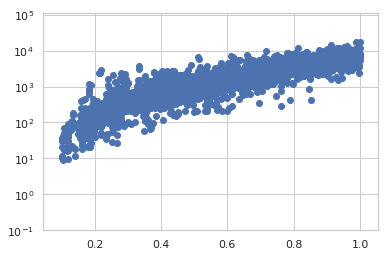

In [39]:
plt.scatter(zcls,nbkgc_true)
plt.yscale('log')
plt.ylim(0.1,)

(array([10.,  0.,  0.,  0.,  2.,  3.,  0.,  0.,  6.,  5.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
 <a list of 10 Patch objects>)

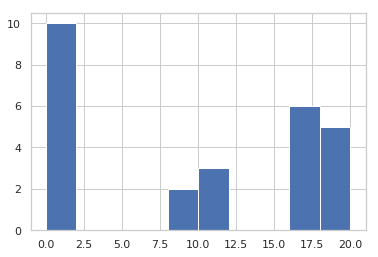

In [40]:
plt.hist(nbkgc_true,bins=np.arange(0,22,2))

In [41]:
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    means = (xedges[1:]+xedges[:-1])/2.
    indices = []
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

def mad(data, axis=None):
    return np.nanmedian(np.abs(data - np.nanmedian(data)))

def get_sigmaNMAD(x):
    sigmaNMAD = 1.48*mad(x)
    return sigmaNMAD

def get_log(x):
    xlog = np.log10(x)
    xlog[np.isinf(xlog)] = -99
    xlog[np.isnan(xlog)] = -99
    return xlog

def get_frac_residual(x,y):
    res = y/(x)
    log_res = get_log(res)
    return res,log_res


In [42]:
def bin_count_residual(Ngt,Ng):
    nbins = np.logspace( np.log10(np.nanmin(Ngt+0.5)), np.log10(np.nanmax(Ngt)),11 )

    residual,log_resiudal = get_frac_residual(Ngt,Ng)

    keys,nmed = get_bins(Ngt,nbins)
    ymed = np.array([np.nanmedian(residual[idx]) for idx in keys])
    yerr = np.array([get_sigmaNMAD(residual[idx]) for idx in keys])
    return [nmed,ymed,np.diff(nbins)/2,yerr]

Text(0.5,0,'Nbkg_true')

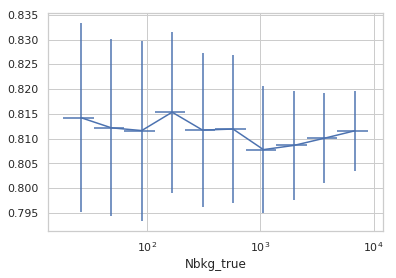

In [43]:
xmed,ymed,xerr,yerr = bin_count_residual(nbkgc,nbkgp)

plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)
plt.xscale('log')
plt.xlabel('Nbkg_true')
# plt.ylim(0.5,.9)
# plt.xlim(5,)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide


Text(0.5,0,'Nbkg_true')

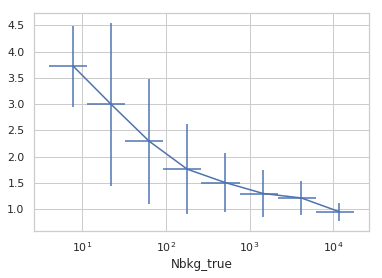

In [45]:
xmed,ymed,xerr,yerr = bin_count_residual(nbkgc_true,nbkgc)

plt.errorbar(xmed,ymed/0.73,xerr=xerr,yerr=yerr)
plt.xscale('log')
plt.xlabel('Nbkg_true')

In [46]:
def bin_redshift_residual(zcls,Ngt,Ng):
    zbins = np.linspace(np.min(zcls),np.max(zcls),21)

    residual,log_resiudal = get_frac_residual(Ngt,Ng)

    keys,zmed = get_bins(zcls,zbins)
    ymed = np.array([np.nanmedian(residual[idx]) for idx in keys])
    yerr = np.array([get_sigmaNMAD(residual[idx]) for idx in keys])
    return [zmed,ymed,np.diff(zbins)/2,yerr]

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide


<ErrorbarContainer object of 3 artists>

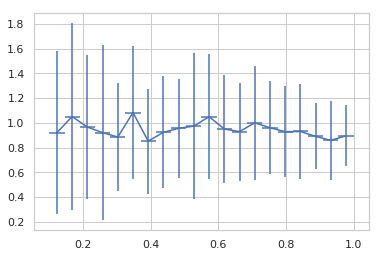

In [48]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc_true,nbkgc)

plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide


<ErrorbarContainer object of 3 artists>

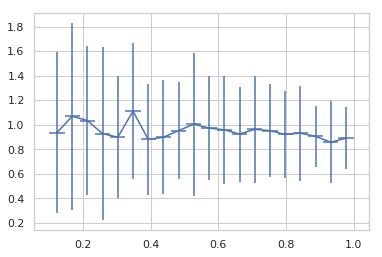

In [49]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgp_true,nbkgp)

plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

In [50]:
def plot_redshift_bin(zcls,y):
    zbins = np.linspace(np.min(zcls),np.max(zcls),21)
    keys,zmed = get_bins(zcls,zbins)
    ymed = np.array([np.nanmean(y[idx]) for idx in keys])
    yerr = np.array([get_sigmaNMAD(y[idx]) for idx in keys])
    
    plt.errorbar(zmed,ymed,xerr=np.diff(zbins)/2,yerr=yerr)
    #plt.scatter(zcls,y,s=10)

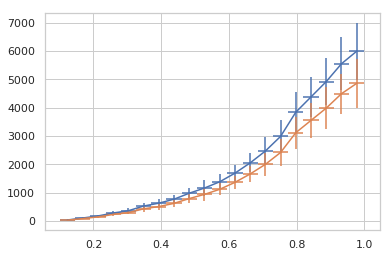

In [51]:
plot_redshift_bin(zcls,nbkgc)
plot_redshift_bin(zcls,nbkgp)

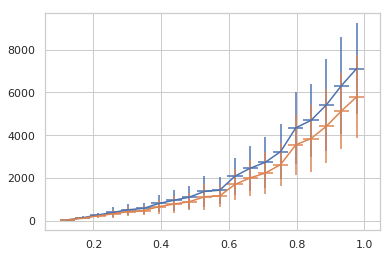

In [52]:
plot_redshift_bin(zcls,nbkgc_true)
plot_redshift_bin(zcls,nbkgp_true)

In [28]:
# xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc/0.73,nbkgc_true)
# plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

# xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgp/0.73,nbkgp_true)
# plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


<ErrorbarContainer object of 3 artists>

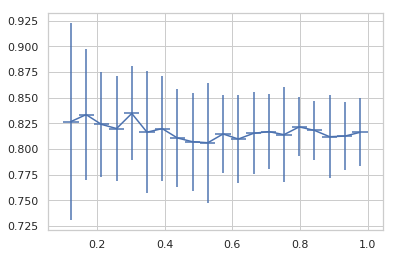

In [29]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc_true,nbkgp_true)
plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


<ErrorbarContainer object of 3 artists>

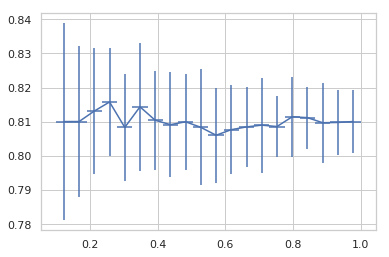

In [30]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc,nbkgp)
plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

# xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc_true,nbkgp_true)
# plt.errorbar(xmed+0.01,ymed,xerr=xerr,yerr=yerr) 

#plt.plot(xmed,correction)

In [23]:
def gaussian(x,mu,sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def gaussian_corrected(x,mu,sigma):
    sigma_cor = sigma*(1+x)
    return np.exp(-(x-mu)**2/(2*sigma_cor**2))/(sigma_cor*np.sqrt(2*np.pi))

In [24]:
import scipy.integrate

def compute_eta(z0,sigma0):
    zmin,zmax = z0-2*sigma0*(1+z0),z0+2*sigma0*(1+z0)
    #zmin = np.where(zmin<0.,0.,zmin)
    out0= scipy.integrate.quad(gaussian,zmin,zmax,args=(z0,sigma0))[0]
    out1= scipy.integrate.quad(gaussian_corrected,zmin,zmax,args=(z0,sigma0))[0]
    return out0-out1

In [25]:
zp = np.linspace(0.1,1.,20)

sigma0 = 0.03
eta = np.array([compute_eta(z0,sigma0) for z0 in zp])

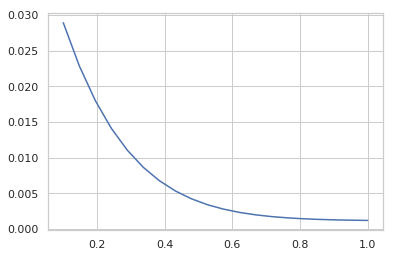

In [343]:
plt.plot(zp,0.0475-eta)

In [344]:
correction = np.array([compute_eta(z0,sigma0) for z0 in zcls])

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


<ErrorbarContainer object of 3 artists>

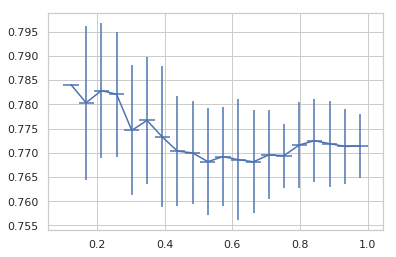

In [345]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc,nbkgp*(1-correction))
plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

# xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc_true,nbkgp_true)
# plt.errorbar(xmed+0.01,ymed,xerr=xerr,yerr=yerr) 

#plt.plot(xmed,correction)

In [332]:
slope = (ymed[-1]-ymed[0])/(0.9)
inter = ymed[0]

In [333]:
correction = slope*xmed+inter

In [27]:
gal = copa.load_copa_out('members',run_name)

Matching Copa output with main and BMA


In [28]:
def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [29]:
true = gal['True_1']


cid  = cat['CID']
gid  = gal['CID'][true]
pz0  = gal['pz0'][true]

keys = list(chunks(gid,cid))

In [30]:
ngalst = np.array([idx.size for idx in keys])
ngals = np.array([np.sum(pz0[idx]) for idx in keys])

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


<ErrorbarContainer object of 3 artists>

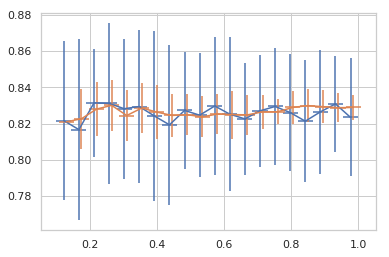

In [31]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,ngalst,ngals)
plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

#xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc,nbkgp)
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc,nbkgp)
plt.errorbar(xmed+0.0075,ymed+0.02,xerr=xerr,yerr=yerr)

In [202]:
zmask = np.abs(gal['zoffset']*(1+gal['redshift_1']))<=2.*gal['zwindow']

In [207]:
pz0 = gal['pz0']
zof = gal['zoffset']

(-0.07, 0.07)

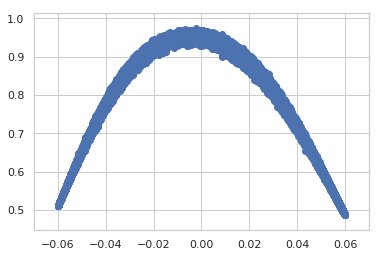

In [211]:
plt.scatter(zof[zmask],pz0[zmask])
plt.xlim(-0.07,0.07)

In [73]:
from make_input_files import load_copa_input_catalog

In [74]:
galaxies, clusters= load_copa_input_catalog(copa.master_fname,
                                            copa.kwargs,pz_file=u'guass003-corr2')



loading clusters
loading full members catalog
making color columns
selecting fake photo-z catalog
making galaxies cut
galaxy catalog
all:  50074070
cut:  12488573
assigning background galaxies
computing physical quantities


In [75]:
zmask   = galaxies['pz0']>0.#np.abs(galaxies['zoffset'])<=2.*galaxies['zwindow']/(1+galaxies['redshift'])
bkgmask = galaxies['Bkg']

In [76]:
bkg_area = np.pi*(copa.kwargs['r_out']**2-copa.kwargs['r_in']**2)

In [77]:
bkg_gal = galaxies[zmask&bkgmask]

In [78]:
galt = galaxies[galaxies['True']]

In [79]:
pz0 = bkg_gal['pz0']
zoff = bkg_gal['zoffset']

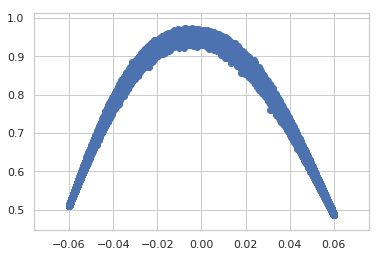

In [80]:
plt.scatter(zoff[::10],pz0[::10])

In [81]:
cid  = clusters['CID']
zcls = clusters['redshift']
gid  = bkg_gal['CID']

keys = list(chunks(gid,cid))

In [82]:
nbkgp = np.array([np.sum(pz0[idx]) for idx in keys])
nbkgc = np.array([np.sum(idx.size) for idx in keys])

<ErrorbarContainer object of 3 artists>

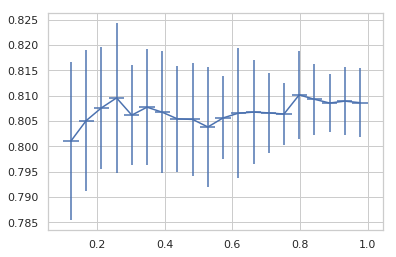

In [83]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc,nbkgp)
plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

# xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc_true,nbkgp_true)
# plt.errorbar(xmed+0.01,ymed,xerr=xerr,yerr=yerr) 


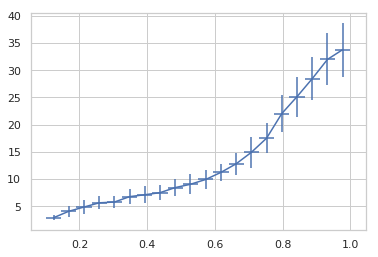

In [94]:
plot_redshift_bin(zcls,nbkgc/bkg_area)

In [84]:
ztrue = bkg_gal['z_true']
ztruet= galt['z_true']

In [85]:
delta_z = 0.01
zbins   = np.arange(0.,1.+delta_z,delta_z)
zmed    = 0.5*(zbins[1:]+zbins[:-1])

In [86]:
nz_bins     = np.histogram(ztrue,zbins,density=True)[0]
nz_bins_cls = np.histogram(ztruet,zbins,density=True)[0]

In [87]:
number_counts = interp1d(zmed, nz_bins, kind='linear', fill_value='extrapolate')
number_counts_cls = interp1d(zmed, nz_bins_cls, kind='linear', fill_value='extrapolate')

Text(0.5,0,'z')

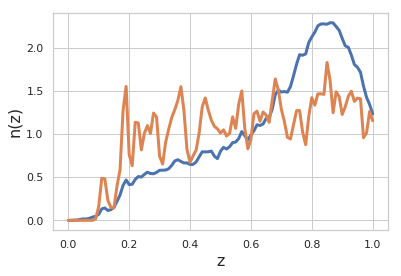

In [88]:
plt.plot(zbins,number_counts(zbins),label='spec-z',lw=3)
plt.plot(zbins,number_counts_cls(zbins),label='cluster galaxies',lw=3)
#plt.plot(zbins,0.5*(1+zbins)**3)
plt.ylabel('n(z)',fontsize=16)
plt.xlabel('z',fontsize=16)
#plt.title('Buzzard v2.0',fontsize=16)

In [89]:
gauss_nz = lambda z, z0, sigma0: gaussian(z,z0,sigma0)*number_counts(z)

def compute_eta(z0,sigma0):
    zmin,zmax = z0-2*sigma0*(1+z0),z0+2*sigma0*(1+z0)
    norm = scipy.integrate.quad(gauss_nz,0.,3.,args=(z0,sigma0))[0]
    out0= scipy.integrate.quad(gauss_nz,zmin,zmax,args=(z0,sigma0))[0]/norm
    out1= scipy.integrate.quad(gaussian_corrected,zmin,zmax,args=(z0,sigma0))[0]
    return out1-out0

In [90]:
zp = np.linspace(0.1,1.,40)

sigma0 = 0.03
eta = np.array([compute_eta(z0,sigma0) for z0 in zp])

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


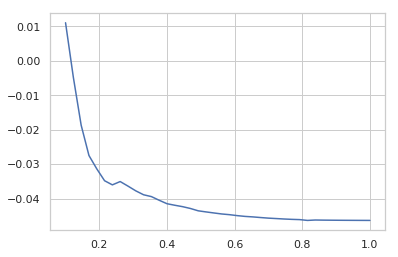

In [294]:
plt.plot(zp,eta)

In [295]:
eta_function = interp1d(zp, eta, 
                        kind='linear', fill_value='extrapolate')

In [296]:
correction = eta_function(zcls)#np.array([compute_eta(z0,sigma0) for z0 in zcls])

<ErrorbarContainer object of 3 artists>

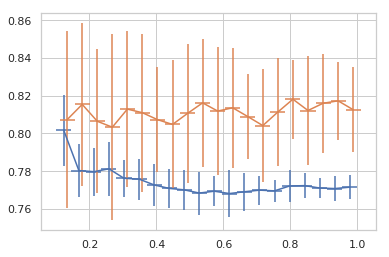

In [299]:
xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc,nbkgp*(1+correction))
plt.errorbar(xmed,ymed,xerr=xerr,yerr=yerr)

xmed,ymed,xerr,yerr = bin_redshift_residual(zcls,nbkgc_true,nbkgp_true)
plt.errorbar(xmed+0.01,ymed,xerr=xerr,yerr=yerr) 

#plt.plot(xmed,correction)

In [298]:
# number_counts_dict = {'all':number_counts,'cls':number_counts_cls}

# global number_counts
# global number_counts_cls
# global number_counts_dict